In [483]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import sys
%matplotlib inline

In [484]:
data = np.load('mnist.npz')

In [485]:
def norm(vecs, axis, keep_dims=False):
    normed = tf.sqrt(tf.reduce_sum(tf.square(vecs), axis=axis, keep_dims=keep_dims))
    return normed

def squash(vecs, axis):
    normed = norm(vecs, axis=axis, keep_dims=True)
    scale = (tf.square(normed)/(tf.square(normed) + 1))/normed
    return scale*vecs


def routing(pred_vecs, num_iters, prior):
    
    #prior: (1, 1152, 10, 1)
    #pred_vecs: (?,1152,10,16)
    
    for i in range(num_iters):
        
        #coupling_coefs: (1, 1152, 10, 1)
        coupling_coefs = tf.nn.softmax(prior, dim=2)
        
        #inputs: (?, 1, 10, 16)
        inputs = tf.reduce_sum(pred_vecs*coupling_coefs, axis=1, keep_dims=True)
        
        #outputs: (?, 1, 10, 16)
        outputs = squash(inputs, axis=-1)

        if (i+1) < num_iters:
            #agreement: (?, 1152, 10, 1)
            agreement = tf.reduce_sum(pred_vecs*outputs, axis=-1, keep_dims=True)
            
            #summed_agreement: (1, 1152, 10, 1)
            mean_agreement = tf.reduce_mean(agreement, axis=0, keep_dims=True)
            
            prior = tf.assign_add(ref=prior, value=mean_agreement)
            tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, prior)
            
    return outputs

def margin_loss(pred_mag, label):
    diff_plus = 0.9 - pred_mag
    diff_minus = pred_mag - 0.1
    return label*tf.square(tf.maximum(diff_plus, 0.)) + 0.5*(1 - label)*tf.square(tf.maximum(diff_minus, 0.))

In [486]:
tf.reset_default_graph()

is_train = tf.placeholder(name='is_train', dtype=tf.bool)

x = tf.placeholder(name='x', dtype=tf.float32, shape=[None,28,28])

x_channels = tf.expand_dims(x, axis=-1)

y = tf.placeholder(name='y', dtype=tf.int32, shape=[None])

yoh = tf.one_hot(y,depth=10)

conv1 = tf.layers.conv2d(inputs=x_channels, filters=256, 
                         kernel_size=9, strides=1,
                         activation=tf.nn.relu)

#primary_capsule = (?,6, 6, 256)
primary_capsule = tf.layers.conv2d(inputs = conv1, filters=256, 
                                kernel_size=9, strides=2,
                                activation=None)
#primary_capsule_out = (?, 1152, 1, 8, 1)
primary_capsule_out = tf.reshape(primary_capsule, (-1,1152,1,8,1))

num_in_capsules = primary_capsule_out.get_shape().as_list()[1]

#outputs = (?, 1152, 1, 8, 1)
outputs = squash(primary_capsule_out, axis=-2)

#weights = (?, 1152, 10, 8, 16)
weights = tf.get_variable('weights', shape=(1,num_in_capsules, 10, 8, 16))

#pred_vecs: (?, 1152, 10, 16)
pred_vecs = tf.reduce_sum(outputs*weights, axis=-2)

#prior: (1, 1152, 10, 1)
prior = tf.get_variable('prior', shape=(1, pred_vecs.get_shape().as_list()[1],10,1), 
                        initializer = tf.zeros_initializer,
                        trainable=False)


#Here in inference we just use the prior as it is and don't update

#capsule_outputs: (?, 1, 10, 16)
capsule_outputs=tf.cond(is_train, lambda: routing(pred_vecs, 3, prior), lambda: routing(pred_vecs, 1, prior))


#capsule_outputs: (?, 10, 16)
capsule_outputs=tf.squeeze(capsule_outputs,axis=1)

masked = tf.reduce_sum(tf.expand_dims(yoh, axis=-1)*capsule_outputs, axis=1)

recon1 = tf.layers.dense(activation=tf.nn.relu, inputs=masked, units=512)
recon2 = tf.layers.dense(activation=tf.nn.relu, inputs=recon1, units=1024)
recon3 = tf.layers.dense(activation = tf.nn.sigmoid, inputs=recon2, units=784)

recon_imgs = tf.reshape(recon3, (-1,28,28))

recon_loss = tf.reduce_mean((recon_imgs-x)**2)

#probs: (?, 10)
probs = norm(capsule_outputs, axis=-1)

preds = tf.argmax(probs, axis=-1)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y, tf.cast(preds, tf.int32)), tf.float32))

margin_losses = margin_loss(probs, yoh)

total_margin_loss = tf.reduce_sum(margin_losses, axis=-1)

avg_margin_loss = tf.reduce_mean(total_margin_loss)

loss = avg_margin_loss + 0.0005*recon_loss 

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    optim = tf.train.AdamOptimizer().minimize(loss)
    


In [487]:
def run_graph(data_x, data_y, batch_size, losses, accs, sess, mode):
    
    def make_slice(n):
        return slice(batch_size*n, batch_size*(n+1))
    
    num_ex = len(data_x)
    batches_per_epoch = math.ceil(num_ex/batch_size)
    shuffle = np.random.permutation(num_ex)
    data_x = data_x[shuffle]
    data_y = data_y[shuffle]
    epoch_loss = epoch_acc = epoch_ml = epoch_rl = 0
    sys.stdout.write('\r\n')
    num_so_far = 0
    for j in range(batches_per_epoch):
        slc = make_slice(j)
        x_b = data_x[slc]
        y_b = data_y[slc]
        num_b = len(x_b)
        fetch = [accuracy, loss, avg_margin_loss, recon_loss] + (mode=='train')*[optim]
        result = sess.run(fetch, {x:x_b, y:y_b, is_train:mode=='train'})
        acc_b, loss_b, ml_b, rl_b = result[:4]
        epoch_loss += loss_b*num_b
        epoch_acc += acc_b*num_b
        epoch_ml += ml_b*num_b
        epoch_rl += rl_b*num_b
        num_so_far+=num_b
        str_1 = '\r{0} batch {1}/{2}'.format(mode.capitalize(), j+1, batches_per_epoch)
        str_2 = ' | {4}_loss: {0:.5f}, {4}_acc: {1:.5f}, {4}_margin_loss: {2:.5f}, {4}_recon_loss: {3:.5f}'\
                         .format(*[m/num_so_far for m in [epoch_loss, epoch_acc, epoch_ml, epoch_rl]], mode)
        sys.stdout.write(str_1 + str_2)
        sys.stdout.flush()
    losses[mode].append(epoch_loss/num_ex)
    accs[mode].append(epoch_acc/num_ex)


def train(data, num_epochs, batch_size, num_samples=10):
    x_train = data['x_train'].astype(np.float32)/255
    y_train = data['y_train'].astype(np.int32)
    x_test = data['x_test'].astype(np.float32)/255
    y_test = data['y_test'].astype(np.int32)
    

    losses = {'train':[],'valid':[]}
    accs = {'train':[],'valid':[]}
    plt.figure()
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(num_epochs):
            if i > 0:
                sys.stdout.write('\n\n')
                
            sys.stdout.write('\rEpoch {0} of {1}'.format(i+1, num_epochs))
            
            run_graph(x_train, y_train, batch_size, losses, accs, sess, 'train')
            run_graph(x_test, y_test, batch_size, losses, accs, sess, 'valid')
            
            
        inds = np.random.randint(0,len(data['x_test']),num_samples)
        sample_imgs = data['x_test'][inds]
        sample_labels = data['y_test'][inds]
        sample_recons = sess.run(recon_imgs, {x:sample_imgs, y:sample_labels, is_train:False})
        
    return losses, accs, sample_imgs, sample_labels, sample_recons

In [488]:
losses, accs, sample_imgs, sample_labels, sample_recons = train(data, 20, 128, num_samples=100)

Epoch 1 of 20
Train batch 469/469 | train_loss: 0.06804, train_acc: 0.93903, train_margin_loss: 0.06799, train_recon_loss: 0.08505
Valid batch 79/79 | valid_loss: 0.02043, valid_acc: 0.98640, valid_margin_loss: 0.02040, valid_recon_loss: 0.05611

Epoch 2 of 20
Train batch 469/469 | train_loss: 0.01854, train_acc: 0.98748, train_margin_loss: 0.01851, train_recon_loss: 0.05421
Valid batch 79/79 | valid_loss: 0.01675, valid_acc: 0.98850, valid_margin_loss: 0.01672, valid_recon_loss: 0.05278

Epoch 3 of 20
Train batch 469/469 | train_loss: 0.01319, train_acc: 0.99178, train_margin_loss: 0.01317, train_recon_loss: 0.05297
Valid batch 79/79 | valid_loss: 0.01208, valid_acc: 0.99100, valid_margin_loss: 0.01206, valid_recon_loss: 0.05226

Epoch 4 of 20
Train batch 469/469 | train_loss: 0.01007, train_acc: 0.99390, train_margin_loss: 0.01005, train_recon_loss: 0.05256
Valid batch 79/79 | valid_loss: 0.01077, valid_acc: 0.99220, valid_margin_loss: 0.01075, valid_recon_loss: 0.05200

Epoch 5 of 2

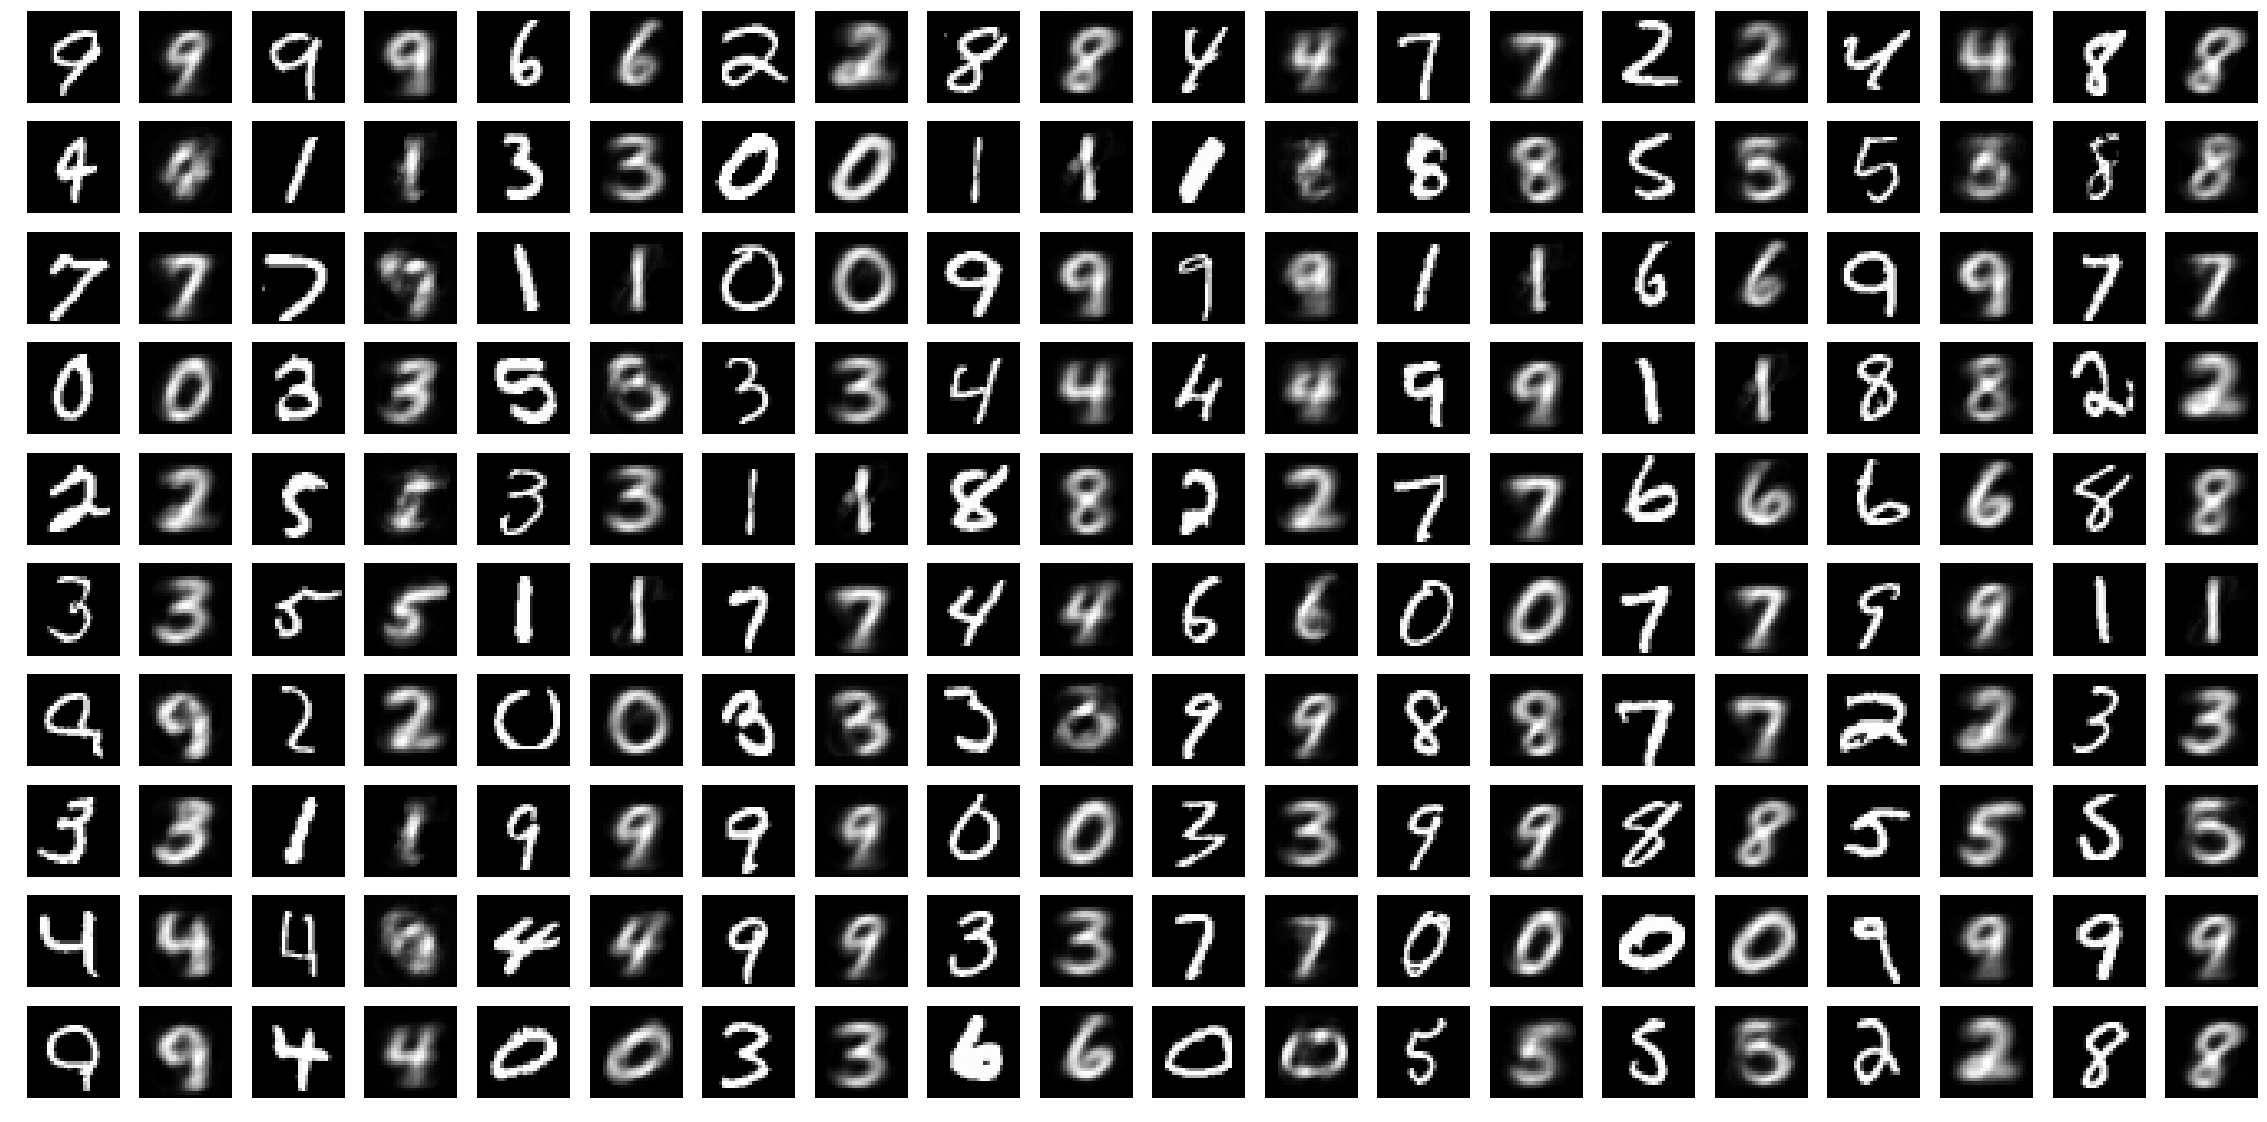

In [506]:
plt.figure(figsize=(40,20))
for i in range(100):
    plt.subplot(10,20,i*2+1)
    plt.imshow(sample_imgs[i],'gray')
    plt.axis('off')
    plt.subplot(10,20,i*2+2)
    plt.imshow(sample_recons[i],'gray')
    plt.axis('off')